# What kinds of officers are involved in shootings?

An examination of officer demographics, and which seem to be disproportionately involved in shootings.

## IMPORTANT NOTES
* Simply because one demographic of officer is involved in more shootings does **not** mean they are more dangerous or more prone to escalation. For example, lower-ranking officers are more likely to be out on patrol in general, and thus should show up more often in shootings, even if they are just as good at de-escalation as higher-ranking officers.

### Datasets used:
* `tji/officer-involved-shootings/shot_civilians.csv`
* `tji/auxiliary-datasets/list_of_texas_officers`

##### Author: Everett Wetchler (everett.wetchler@gmail.com)

In [1]:
from lib import PlotSaver, percentify_x, percentify_y

plotsaver = PlotSaver('../plots/', 'ois_which_officers_')

Removing 0 past plots


/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

import datetime as dt
import os
import random

import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Personal libraries
import evutils.everett_eda as eda

## Jupyter setup
%matplotlib inline

## Graphical setup
# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
SNS_COLORS = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Watermark extension to print version/system information
# Flags:
# -a [author] -d (date) -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version) -p [packages] (package info)
%load_ext watermark
%watermark -a "Everett Wetchler" -d -t -z -w -p numpy,pandas,matplotlib,datadotworld

####################################################
# END Boilerplate
####################################################

Everett Wetchler 2018-05-15 14:13:19 CDT

numpy 1.14.3
pandas 0.20.1
matplotlib 2.2.0
datadotworld 1.6.0
watermark 1.5.0


In [3]:
def long_gender_name(g):
    if pd.isnull(g):
        return g
    return 'MALE' if g.startswith('M') else 'FEMALE'

In [4]:
datasets = dw.load_dataset('tji/officer-involved-shootings', force_update=True)
shot_civ = datasets.dataframes['shot_civilians']
shot_civ.head()

,date_incident,incident_address,incident_city,incident_county,incident_zip,incident_latitude,incident_longitude,incident_result_of,incident_call_other,civilian_name_first,civilian_name_last,civilian_gender,civilian_age,civilian_race,civilian_died,officer_age_1,officer_race_1,officer_gender_1,agency_name_1,agency_report_date_1,agency_city_1,agency_county_1,agency_zip_1,agency_name_person_filling_out_1,agency_email_person_filling_out_1,officer_age_2,officer_race_2,officer_gender_2,officer_caused_injury_2,agency_name_2,agency_report_date_2,agency_city_2,agency_county_2,agency_zip_2,agency_name_person_filling_out_2,agency_email_person_filling_out_2,officer_age_3,officer_race_3,officer_gender_3,officer_caused_injury_3,agency_name_3,agency_report_date_3,agency_city_3,agency_county_3,agency_zip_3,agency_name_person_filling_out_3,agency_email_person_filling_out_3,officer_age_4,officer_race_4,officer_gender_4,...,agency_email_person_filling_out_7,officer_age_8,officer_race_8,officer_gender_8,agency_name_8,agency_report_date_8,agency_city_8,agency_county_8,agency_zip_8,agency_name_person_filling_out_8,agency_email_person_filling_out_8,officer_age_9,officer_race_9,officer_gender_9,agency_name_9,agency_report_date_9,agency_city_9,agency_county_9,agency_zip_9,agency_name_person_filling_out_9,agency_email_person_filling_out_9,officer_age_10,officer_race_10,officer_gender_10,agency_name_10,agency_report_date_10,agency_city_10,agency_county_10,agency_zip_10,agency_name_person_filling_out_10,agency_email_person_filling_out_10,news_coverage_1,news_coverage_2,news_coverage_3,news_coverage_4,cdr_narrative,custodial_death_report,deadly_weapon,deadly_weapon_category,deadly_weapon_description,extras,lea_narrative_published,lea_narrative_shorter,multiple_officers_involved,num_officers_recorded,num_reports_filed,num_rows_about_this_incident,officer_on_duty,time_incident,incident_location
0,2015-09-02,1010 MAGNOLIA STREET,FREEPORT,BRAZORIA,77541.0,28.944891,-95.356262,TRAFFIC STOP,NARCOTIC STOP AND EVADING ARREST,RICKEY,MAYBERRY,M,30.0,BLACK,False,27.0,HISPANIC,M,FREEPORT POLICE DEPT,9/16/2015,FREEPORT,BRAZORIA,77541,PAMELA MORRIS,PMORRIS@FREEPORT.TX.US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,ABC 13,YOUR SOUTHEST TEXAS,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,True,1,1,1,True,NaN,POINT(-95.3562616 28.9448909)
1,2015-09-03,4840 E. PLANO PARKWAY,PLANO,COLLIN,75074.0,33.008128,-96.642308,OTHER - SPECIFY TYPE OF CALL,ACCIDENTAL DISCHARGE RICOCHET DURING RANGE ACT...,NaN,NaN,M,55.0,WHITE,False,30.0,HISPANIC,M,PLANO POLICE DEPT,10/1/2015,PLANO,COLLIN,75074,CURTIS HOWARD,CURTISH@PLANO.GOV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,(DETAILS MISSING),NaN,NaN,NaN,NaN,False,1,1,1,True,NaN,POINT(-96.6423077 33.0081284)
2,2015-09-04,101 COUCH CT.,SPRINGTOWN,PARKER,76082.0,32.916724,-97.634194,OTHER - SPECIFY TYPE OF CALL,INVESTIGATION OF CRIMINAL ACTIVITY,SULLY JOE,LANIER,M,36.0,WHITE,True,27.0,WHITE,M,PARKER CO SHERIFFS OFFICE,10/6/2015,WEATHERFORD,PARKER,76086,MEREDITH GRAY,MEREDITH.GRAY@PARKERCOUNTYTX.COM,56.0,WHITE,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,WFAA,DFW CBS LOCAL,STAR TELEGRAM,FOX 4 NEWS,DECEDENT SHOT A RIFLE AT LE OFFICERS WHOM RETU...,True,True,FIREARM,FIREARM,NaN,NaN,FIRED AT OFFICERS,True,2,1,1,True,NaN,POINT(-97.6341935 32.9167242)
3,2015-09-05,4926 CHENNAULT ROAD,HOUSTON,HARRIS,77033.0,29.681655,-95.344966,EMERGENCY CALL OR REQUEST FOR ASSISTANCE,NaN,NaN,NaN,M,21.0,BLACK,F

In [5]:
shot_civ = shot_civ.drop_duplicates(subset=['incident_address', 'date_incident'])
print('Dropped %d rows beyond the first for an incident' % (len(shot_civ) - len(shot_civ)))

Dropped 0 rows beyond the first for an incident


In [6]:
ois_officers = []
for i in range(1, 11):
    for age, gender in zip(shot_civ['officer_age_%d' % i], shot_civ['officer_gender_%d' % i]):
        if pd.isnull(age) or pd.isnull(gender):
            continue
        ois_officers.append((int(age), long_gender_name(gender)))
ois_officers = pd.DataFrame(ois_officers, columns=['age', 'gender'])
ois_officers.head()

,age,gender
0,27,MALE
1,30,MALE
2,27,MALE
3,28,MALE
4,38,MALE


In [7]:
OFFICER_BEGIN_SERVICE_AGE = 21

dataset = dw.load_dataset('tji/auxiliary-datasets', force_update=True)
officer_info = dataset.dataframes['list_of_texas_officers']
officer_info['age_presumed'] = (officer_info.service_time + OFFICER_BEGIN_SERVICE_AGE).astype(int)
officer_info['gender'] = officer_info.gender.apply(long_gender_name)
officer_info['is_male'] = officer_info.gender.apply(lambda g: g if pd.isnull(g) else g == 'MALE').astype(float)
officer_info.head()

,name_full,name_first,name_middle,name_last,name_suffix,gender,race,age_range,current_agency,current_agency_county,highest_cert,highest_cert_int,service_time,age_presumed,is_male
0,DALE E SCHNELLE,DALE,E,SCHNELLE,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 1,ANDERSON,MASTER PEACE OFFICER,4,23.00,44,1.0
1,GARY D THOMAS,GARY,D,THOMAS,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 1,ANDERSON,MASTER PEACE OFFICER,4,43.08,64,1.0
2,CHARLES D LIGHTFOOT,CHARLES,D,LIGHTFOOT,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 2,ANDERSON,MASTER PEACE OFFICER,4,24.67,45,1.0
3,WILLIAM R WATTS,WILLIAM,R,WATTS,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 2,ANDERSON,MASTER PEACE OFFICER,4,23.33,44,1.0
4,KIMBERLY S HOLLIDAY,KIMBERLY,S,HOLLIDAY,NaN,FEMALE,WHITE,51+,ANDERSON CO CONST PCT 3,ANDERSON,MASTER PEACE OFFICER,4,17.33,38,0.0


## Begin analysis

In [8]:
LABEL_OIS = 'Officers involved\nin shootings'
LABEL_ALL = 'All TX officers'

### Are officers of certain _ages_ disproportionately likely to be involved in shootings?

/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


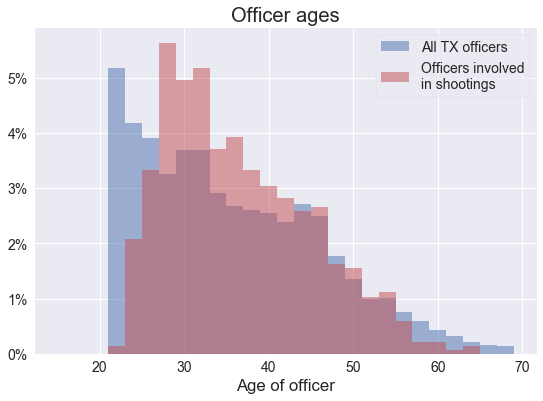

In [9]:
fig, ax = plt.subplots()
bins = np.arange(15, 71, 2)
officer_info.age_presumed.hist(ax=ax, normed=True, color=SNS_BLUE, label=LABEL_ALL, bins=bins, alpha=0.5)
ois_officers.age.hist(ax=ax, normed=True, label=LABEL_OIS, bins=bins, alpha=0.5, color=SNS_RED)
ax.set_title('Officer ages')
ax.set_xlabel('Age of officer')
percentify_y(ax, decimals=0)
ax.legend()

plotsaver.saveplot(fig, 'age')

### Are officers of certain _genders_ disproportionately likely to be involved in shootings?

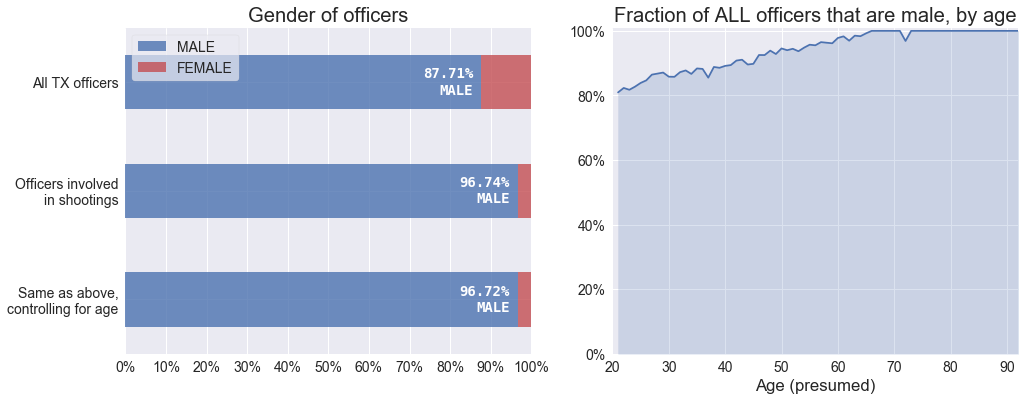

In [10]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 6)


# First plot - gender breakdown for all officers vs those in shootings


s1 = officer_info.gender.value_counts(True)
s1.name=LABEL_ALL
s2 = ois_officers.gender.value_counts(True)
s2.name=LABEL_OIS

# We will find that more men are involved in shootings, but above we
# also saw that older officers are more likely to be involved.
# Since older officers are already more likely to be male (see second plot),
# the naive approach would overstate the male-ness of officers involved
# in shootings.
# We add a third bar controlling for this fact. We weight each officer
# involved in a shooting by the odds that a randomly-chosen officer their
# age would be male. If, say, 22 year old officers are 80% male, this would
# earn a weight of 1 / 0.8 = 1.25. If 100% were male, the weight would be 1.

age_male_fraction = officer_info.groupby('age_presumed')['is_male'].mean().sort_index()
weights = []
for age, gender in zip(ois_officers.age, ois_officers.gender):
    if pd.isnull(age) or pd.isnull(gender):
        weights.append(np.nan)
    else:
        weights.append(1/age_male_fraction.loc[age])
ois_officers['weight'] = weights
total_weight = ois_officers['weight'].sum()
s3 = ois_officers.groupby('gender')['weight'].sum() / total_weight
s3.name = 'Same as above,\ncontrolling for age'

ax = axes[0]
ax.set_title('Gender of officers')
gender_df = pd.concat([s3, s2, s1], axis=1).T
gender_df = gender_df[['MALE', 'FEMALE']]
gender_df.plot(kind='barh', ax=ax, stacked=True, alpha=0.8, color=[SNS_BLUE, SNS_RED])
percentify_x(ax)
ax.set_xticks(np.arange(0, 1.01, .1))
ax.set_xlim(0, 1)
ax.legend()
fontstyle = {
    'color': 'white',
    'verticalalignment': 'center',
    'weight': 'bold',
    'family': 'monospace',
    'horizontalalignment': 'right',
}
ax.text(s1.loc['MALE'] - 0.02, 2, "%.2f%%\nMALE" % (s1.loc['MALE'] * 100), fontdict=fontstyle)
ax.text(s2.loc['MALE'] - 0.02, 1, "%.2f%%\nMALE" % (s2.loc['MALE'] * 100), fontdict=fontstyle)
ax.text(s3.loc['MALE'] - 0.02, 0, "%.2f%%\nMALE" % (s3.loc['MALE'] * 100), fontdict=fontstyle)


# Second plot - fraction of the force that is male, by age


ax=axes[1]
ax.set_title('Fraction of ALL officers that are male, by age')
s4 = officer_info.groupby('age_presumed')['is_male'].mean().sort_index()
s4.plot(ax=ax)
ax.fill_between(s4.index, s4.values, [0] * len(s4), color=SNS_BLUE, alpha=0.2)
ax.set_ylim(0, 1.01)
ax.set_xlim(20, ax.get_xlim()[1])
percentify_y(ax)
ax.set_xlabel('Age (presumed)')

plotsaver.saveplot(fig, 'gender')